In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#https://stooq.pl/q/d/?s=aapl.us
apple_data = pd.read_csv('aapl_us_d (1).csv')
closing_prices=apple_data['Zamkniecie'].values
dates=apple_data['Data'].values
closing_prices = closing_prices[-1000:]
dates= dates[-1000:]
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

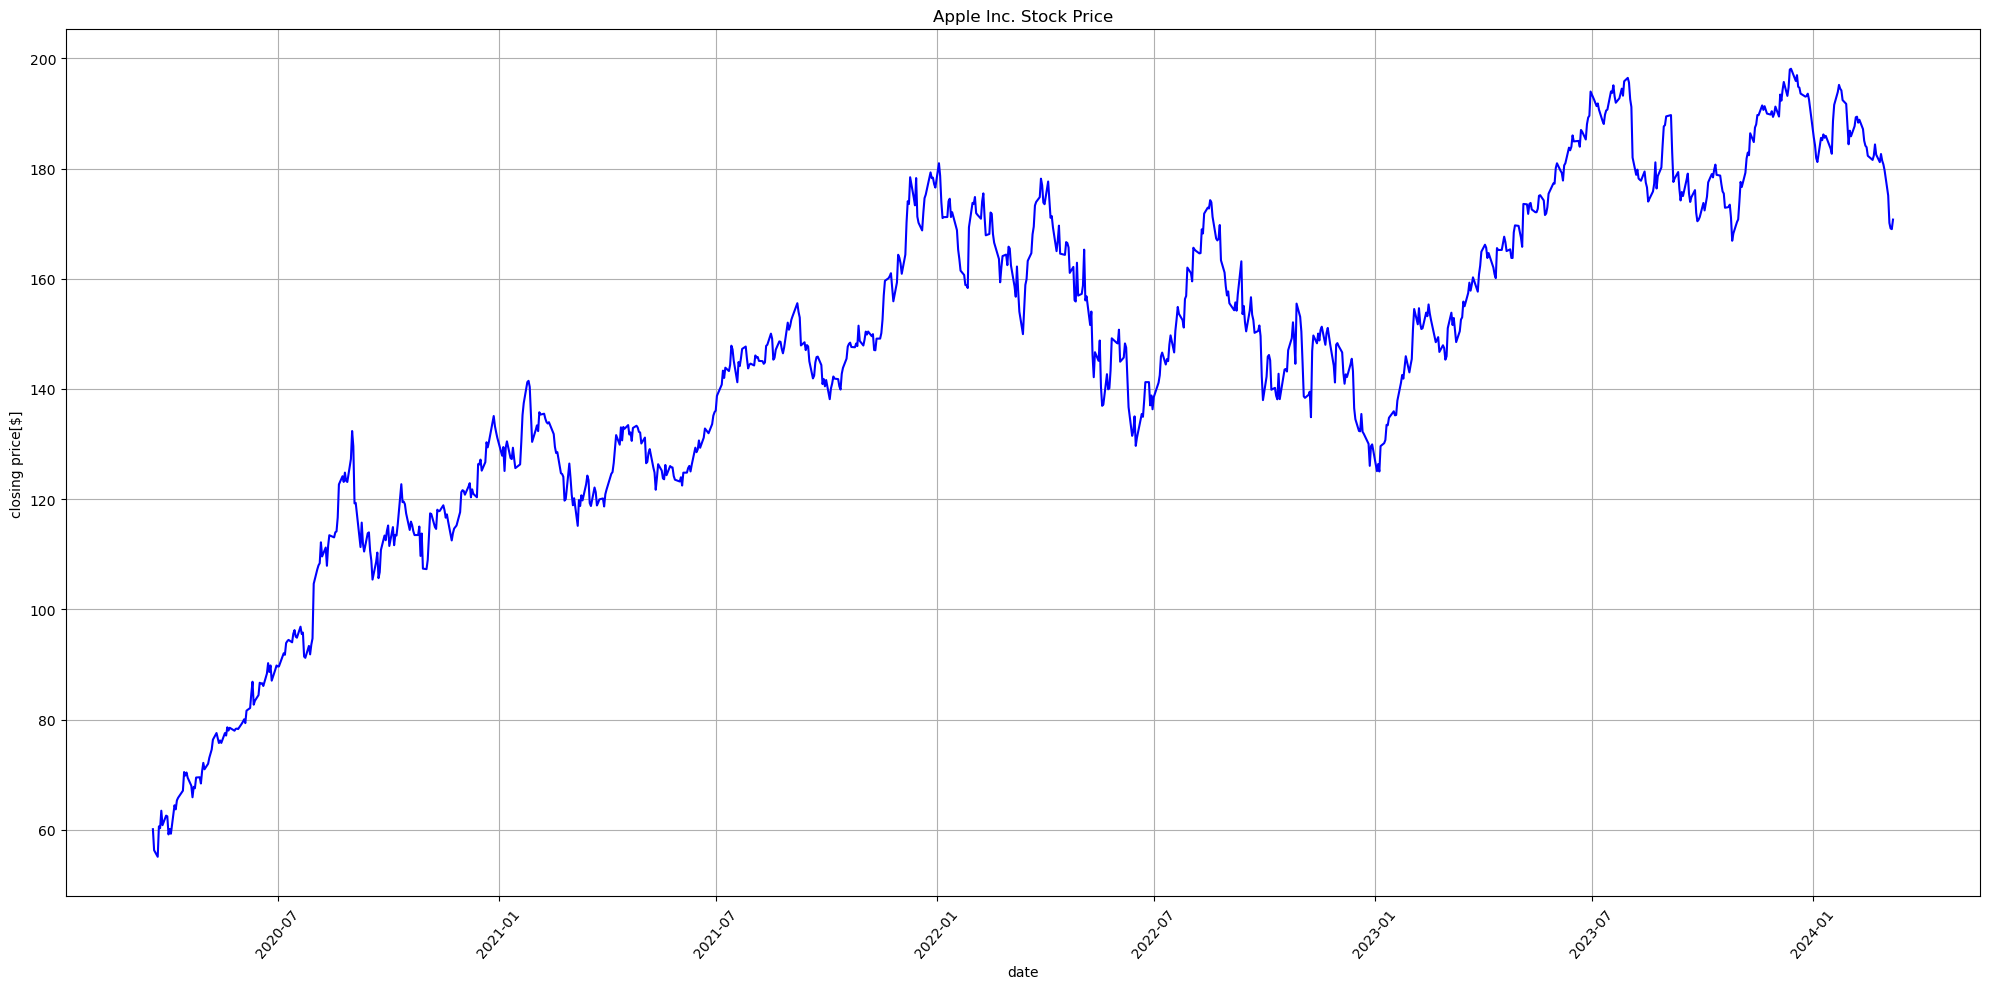

In [3]:
plt.figure(figsize=(20, 10))
plt.plot(dates, closing_prices, color='blue')
plt.title('Apple Inc. Stock Price')
plt.xlabel('date')
plt.ylabel('closing price[$]')
plt.grid(True)
plt.xticks(rotation=50)
plt.tight_layout()
plt.savefig('wykres1.png')
plt.show()

In [4]:
def calc_result(vector, number, period):#obliczanie wykładniczej średniej kroczącącej dla N okresów
    sum_exp = vector[number]
    sum_den = 1
    for i in range(1, period + 1):
        sum_exp += ((1 - 2 / (period + 1)) ** i) * vector[number-i]
        sum_den += ((1 - 2 / (period + 1)) ** i)
    result=sum_exp/sum_den
    return result

def calc_ema(vector,period):#obliczanie wskaźnika ema dla wszystkich danych z wektora
    ema=[]
    number = 0
    for element in vector:
        if number>=period:
            ema.append(calc_result(vector,number,period))
        else:#jeśli nie można cofnąć się o określony okres to następuje cofnięcie się o max liczbę dni
            p=number
            ema.append(calc_result(vector,number,p))
        number+=1
    return ema

def calc_points(macd,signal):#obliczenie punktów przecięcia
    sell=[]
    buy=[]
    for i in range(1,len(macd)):
        if (macd[i-1]>signal[i-1] and macd[i]<signal[i]):#macd przecina signal z góry
            sell.append(i)
        if (macd[i-1]<signal[i-1] and macd[i]>signal[i]):#macd przecina signal z dołu
            buy.append(i)
    return sell,buy

def plot_stock_figure(dates,closing_prices,sell_points,buy_points,size_x,size_y,name):
    plt.figure(figsize=(size_x, size_y))
    plt.plot(dates, closing_prices,label='closing price', color='blue')
    plt.scatter([dates[i] for i in sell_points], [closing_prices[i] for i in sell_points], color='green', label='Sell Points', s=150)
    plt.scatter([dates[i] for i in buy_points], [closing_prices[i] for i in buy_points], color='yellow', label='Buy Points', s=150)
    plt.legend()
    plt.title('Apple Inc. Stock Price with buying/selling points')
    plt.xlabel('date')
    plt.ylabel('closing price[$]')
    plt.grid(True)
    plt.xticks(rotation=50)
    plt.tight_layout()
    plt.savefig(name)
    plt.show()

def plot_MACD_figure(dates,macd,signal,sell_points,buy_points,size_x,size_y,name):
    plt.figure(figsize=(size_x, size_y))
    plt.plot(dates, macd,label='MACD', color='blue')
    plt.plot(dates, signal,label='SIGNAL', color='red')
    plt.scatter([dates[i] for i in sell_points], [macd[i] for i in sell_points], color='green', label='Sell Points', s=150)
    plt.scatter([dates[i] for i in buy_points], [macd[i] for i in buy_points], color='yellow', label='Buy Points', s=150)
    plt.legend()
    plt.title('MACD+SIGNAL with buying/selling points')
    plt.xlabel('date')
    plt.ylabel('value')
    plt.grid(True)
    plt.xticks(rotation=50)
    plt.tight_layout()
    plt.savefig(name)
    plt.show()

def plot_figure_fragment(start_date,end_date,name,name2):
    selected_dates = []
    selected_closing_prices=[]
    macd_fragment=[]
    signal_fragment=[]
    data_df = pd.DataFrame({'dates': dates})
    start_index = data_df.loc[data_df['dates'] == start_date].index[0]
    end_index = data_df.loc[data_df['dates'] == end_date].index[0]
    
    i = start_index
    while i < end_index:
        selected_dates.append(dates[i])
        selected_closing_prices.append(closing_prices[i])
        macd_fragment.append(macd[i])
        signal_fragment.append(signal[i])
        i = i + 1
    
    sell_points_fragment,buy_points_fragment=calc_points(macd_fragment,signal_fragment)
    plot_MACD_figure(selected_dates,macd_fragment,signal_fragment,sell_points_fragment,buy_points_fragment,10,5,name)
    plot_stock_figure(selected_dates,selected_closing_prices,sell_points_fragment,buy_points_fragment,10,5,name2)
    

ema12=calc_ema(closing_prices,12)
ema26=calc_ema(closing_prices,26)
ema_df = pd.DataFrame({'EMA12': ema12, 'EMA26': ema26})
macd = ema_df['EMA12'] - ema_df['EMA26']
signal=calc_ema(macd,9)
sell_points,buy_points=calc_points(macd,signal)

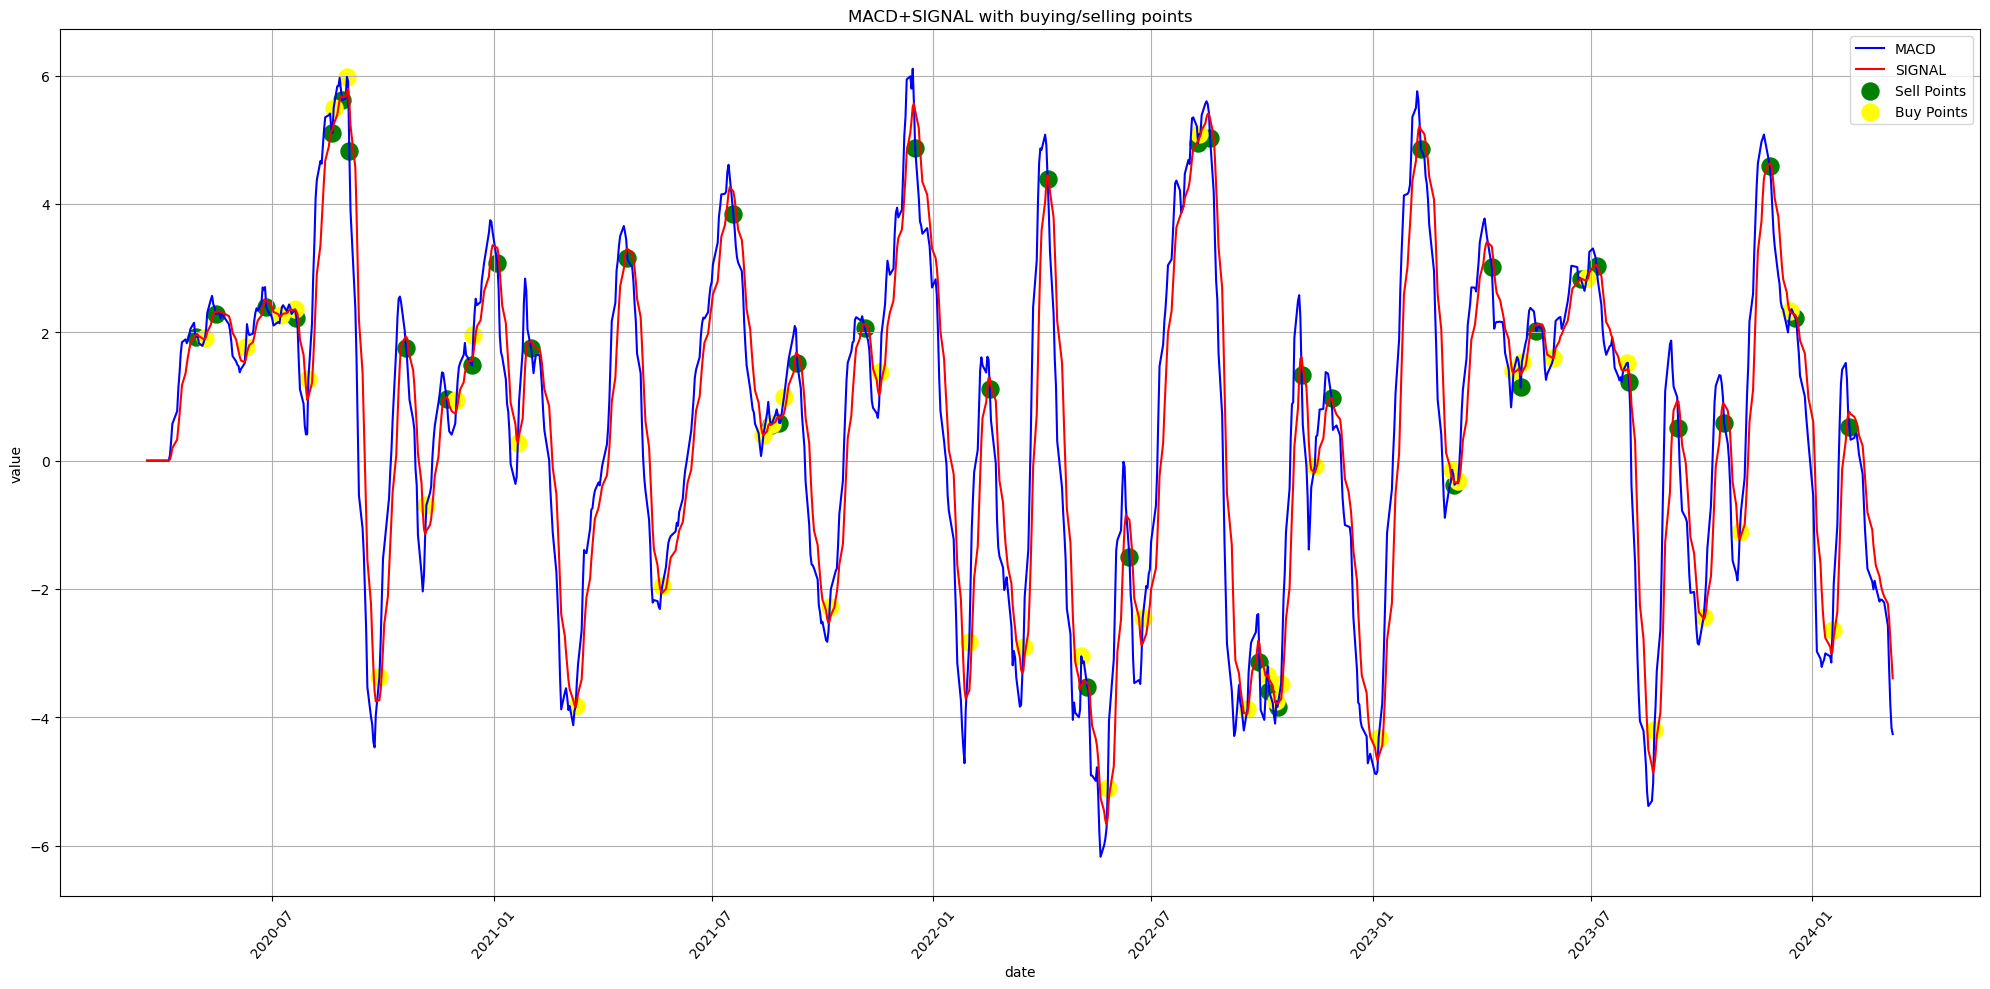

In [5]:
 plot_MACD_figure(dates,macd,signal,sell_points,buy_points,20,10,'wykres2.png')

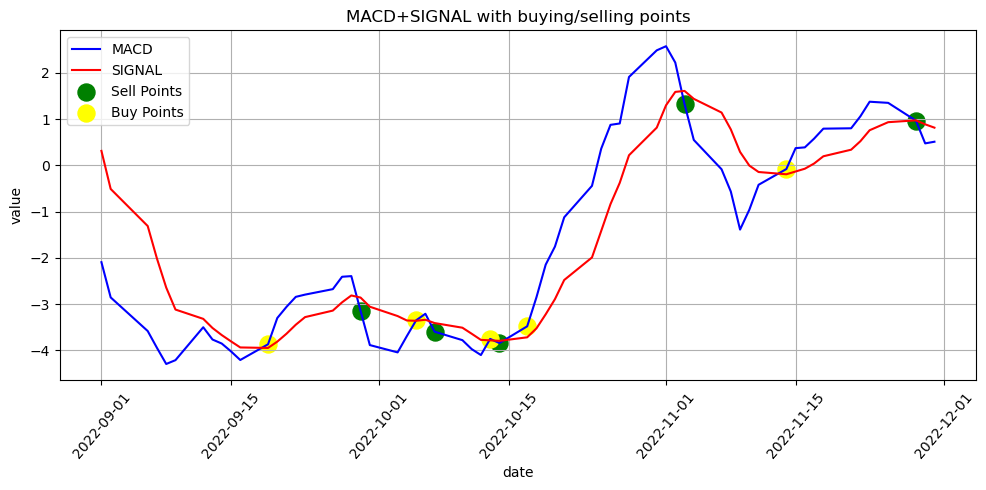

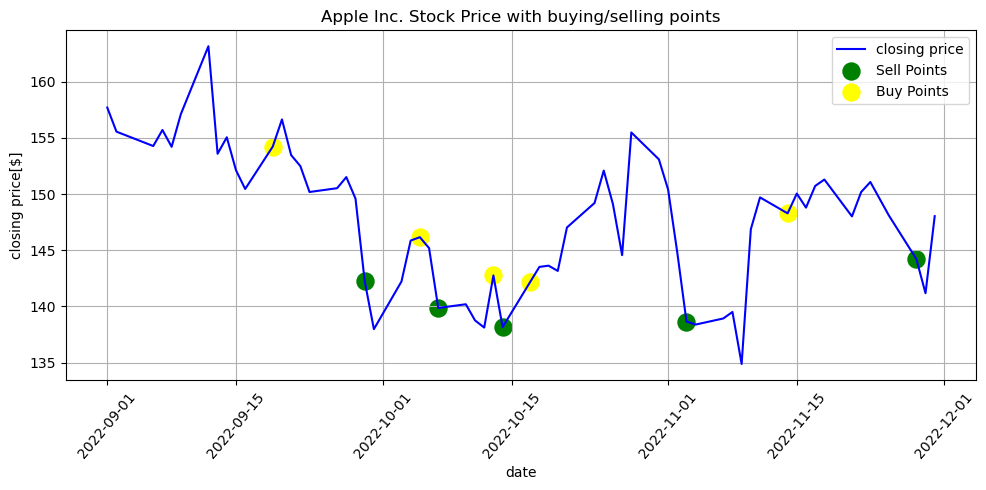

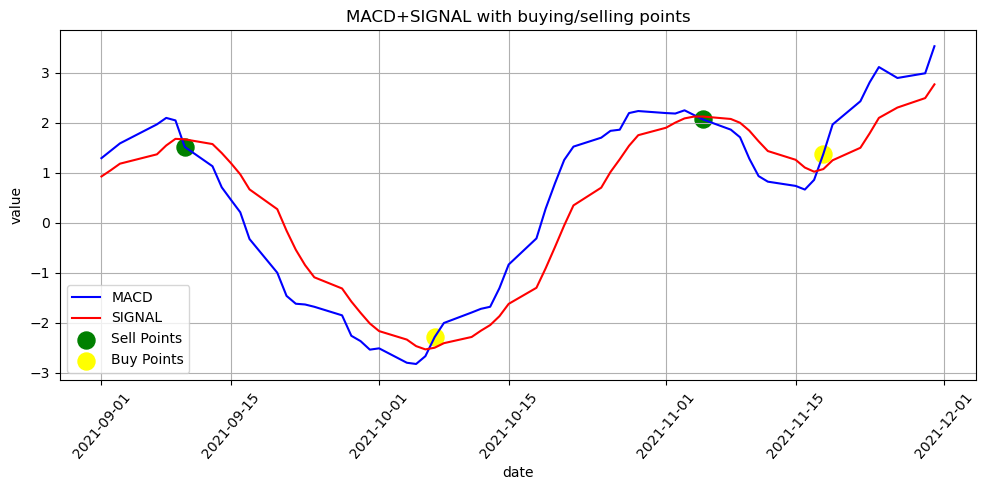

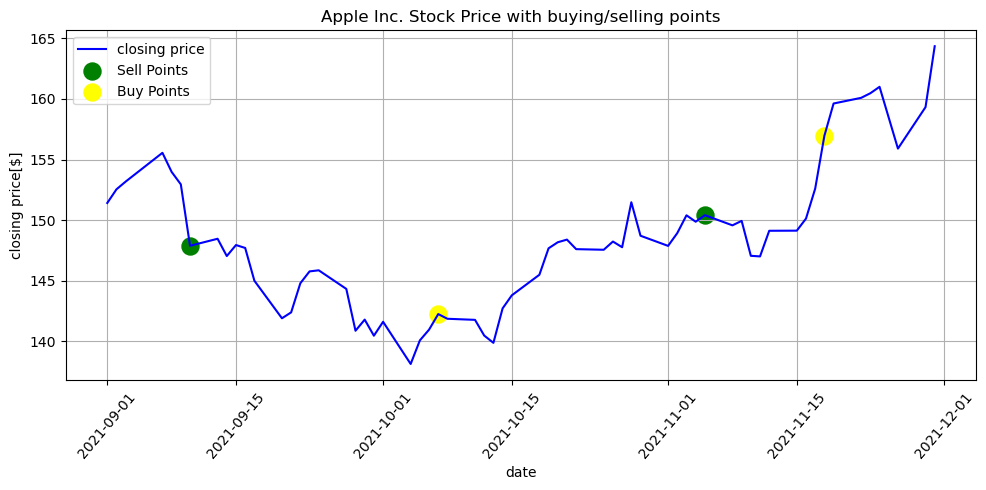

In [6]:
plot_figure_fragment(datetime(2022, 9, 1, 0, 0, 0),datetime(2022, 12, 1, 0, 0, 0),'wykres3.png','wykres4.png')
plot_figure_fragment(datetime(2021, 9, 1, 0, 0, 0),datetime(2021, 12, 1, 0, 0, 0),'wykres5.png','wykres6.png')

In [7]:
#mamy 1000 kapitalu
#Miejsce, w którym MACD przecina SIGNAL od
#dołu jest sygnałem do zakupu akcji. Miejsce, w którym MACD przecina SIGNAL od
#góry, jest sygnałem do sprzedaży akcji.

def buy_or_sell_action(macd,signal,closing_prices,dates,own_actions,start_dates,end_date):
    capital=0
    balance=[]
    current_dates=[]
    for i in range(1,len(macd)):
        if start_date<=dates[i-1]<=end_date:
            if macd[i-1]>signal[i-1] and macd[i]<signal[i] and own_actions>0:
                capital+=own_actions*closing_prices[i]
                capital=round(capital,2)
                own_actions=0
            elif macd[i-1]<signal[i-1] and macd[i]>signal[i] and capital>0:
                actions_to_buy=capital/closing_prices[i]
                actions_to_buy=round(actions_to_buy,2)
                own_actions+=actions_to_buy
                capital-=actions_to_buy*closing_prices[i]
                capital=round(capital,2)
            final_capital=capital + own_actions * closing_prices[i]
            print(final_capital)
            capital=round(capital,2)
            balance.append(final_capital)
            current_dates.append(dates[i])
    return balance,current_dates,final_capital
start_date = dates[0]
end_date = dates[999] 
balance,current_dates,final_capital= buy_or_sell_action(macd,signal,closing_prices,dates,1000,start_date,end_date)
    

56278.3
55084.0
60608.2
60277.1
63446.5
60821.5
62556.2
62426.5
59145.6
60130.6
59268.2
64437.399999999994
63689.700000000004
65318.700000000004
65793.40000000001
67083.4
70472.0
69828.0
70384.3
69427.2
67984.6
65887.0
67781.3
67521.1
69470.1
69520.0
68392.3
70636.5
70636.5
70636.5
70636.5
70636.5
70636.49557599999
71363.55886399999
73062.879088
74213.52828
73364.250984
72480.80735999999
72923.53406399999
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.07
72495.069301
74360.062893
70791.45621399999
71401.791291
72285.060612
74200.394648
74097.14537
74127.024307
73702.811892
75631.844008
77246.676414
75881.063451
76888.12917
74528.21
74528.21
74528.21
74528.21
74528.21
74528.21
74528.21
74528.21235599999
74795.67052799999
74980.088852
74634.195336
75869.71078
76392.8777
75451.81234799999
75299.86
75299.85875
74260.5
74260.5
74260.5
74260.5
74260.5
74260.5
74260.5
74260.5
74260.49519999999
76121.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


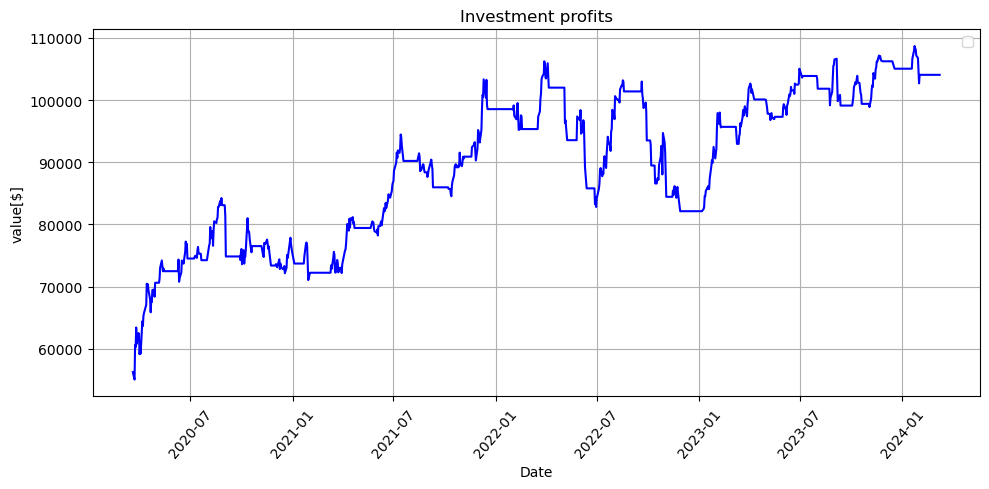

In [8]:
#wykres zysków i strat
plt.figure(figsize=(10, 5))
plt.plot(current_dates, balance, color='blue')
plt.legend()
plt.title('Investment profits')
plt.xlabel('Date')
plt.ylabel('value[$]')
plt.grid(True)
plt.xticks(rotation=50)
plt.tight_layout()
plt.savefig("wykres7.png")
plt.show()
